In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/naruto/data/nithish/11.png
/kaggle/input/naruto/data/nithish/4.png
/kaggle/input/naruto/data/nithish/9.png
/kaggle/input/naruto/data/nithish/1.png
/kaggle/input/naruto/data/nithish/2.png
/kaggle/input/naruto/data/nithish/10.png
/kaggle/input/naruto/data/nithish/12.png
/kaggle/input/naruto/data/nithish/7.png
/kaggle/input/naruto/data/nithish/5.png
/kaggle/input/naruto/data/nithish/3.png
/kaggle/input/naruto/data/nithish/8.png
/kaggle/input/naruto/data/nithish/6.png
/kaggle/input/naruto/data/naruto/11.png
/kaggle/input/naruto/data/naruto/4.png
/kaggle/input/naruto/data/naruto/9.png
/kaggle/input/naruto/data/naruto/1.png
/kaggle/input/naruto/data/naruto/2.png
/kaggle/input/naruto/data/naruto/7.png
/kaggle/input/naruto/data/naruto/5.png
/kaggle/input/naruto/data/naruto/3.png
/kaggle/input/naruto/data/naruto/8.png


# General Import

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time 
import torch.nn.functional as F
from torchvision import datasets
import torchvision
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split
from torch.utils.data import sampler
from tempfile import TemporaryDirectory
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.colors as mcolors
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Required hyperparameter

In [3]:
RANDOM_SEED = 49
LEARNING_RATE = 0.001
BATCH_SIZE = 256
NUM_EPOCHS = 30
NUM_CLASSES = 2

# Creating the Dataloader

In [4]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Ensure images are resized to 244x244
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Ensure images are resized to 244x244
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
#load the dataset 
dataset = datasets.ImageFolder(root='/kaggle/input/naruto/data/')

# Define the train-validation split ratio
train_ratio = 0.7
val_ratio = 0.3
total_size = len(dataset)
train_size = int(total_size * train_ratio)
val_size = total_size - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Apply transformations to the datasets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Create DataLoader
dataloaders = {
    
    'train' : DataLoader(dataset=train_dataset, batch_size=6, shuffle=True),
    'val'   : DataLoader(dataset=val_dataset, batch_size=6, shuffle=False)
    
}

# Calculate dataset sizes
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

In [5]:
print(dataset.class_to_idx)
class_names = list(dataset.class_to_idx.keys())
print("Class names",class_names)

{'naruto': 0, 'nithish': 1}
Class names ['naruto', 'nithish']


# Image Visualization

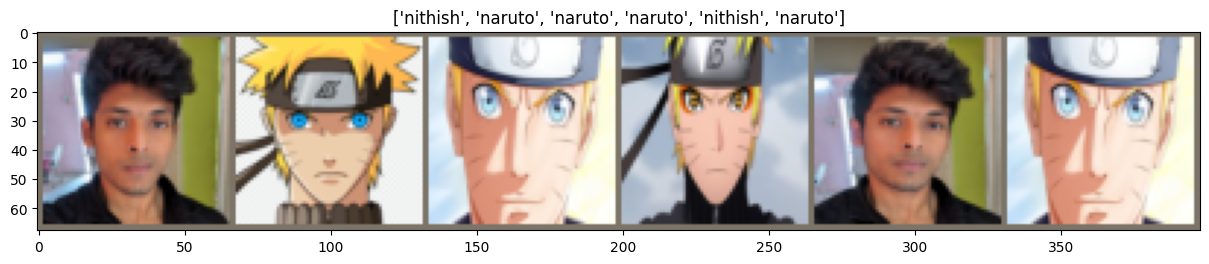

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
#setting the figure size
plt.figure(figsize=(15,15))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#function call to show the image
imshow(out, title=[class_names[x] for x in classes])

In [7]:
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Defining the Model 

In [8]:
import torch
import torch.nn as nn

class DeepAutoencoder(nn.Module):
    def __init__(self):
        super(DeepAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64 * 3, 512),  # Adjusted for 64x64 input size
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 64 * 64 * 3),  # Match the encoder's initial layer
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # Reshape the output to the original image shape
        decoded = decoded.view(x.size(0), 3, 64, 64)
        return decoded

# Example usage
model = DeepAutoencoder()
print(model)


DeepAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=12288, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=12288, bias=True)
    (9): Sigmoid()
  )
)


In [9]:
model = model.to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.MSELoss()


# Model Traning Script

In [10]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, _ in dataloaders[phase]:
                    inputs = inputs.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward
                    # Track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, inputs)  # Use inputs as targets

                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f}')

                # Deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Loss: {best_loss:4f}')

        # Load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

# Training

In [11]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,dataloaders,dataset_sizes,device,num_epochs=100)

Epoch 0/99
----------
train Loss: 1.5913
val Loss: 1.4750

Epoch 1/99
----------
train Loss: 1.4707
val Loss: 1.4051

Epoch 2/99
----------
train Loss: 1.3006
val Loss: 1.3763

Epoch 3/99
----------
train Loss: 1.2725
val Loss: 1.3246

Epoch 4/99
----------
train Loss: 1.2393
val Loss: 1.2369

Epoch 5/99
----------
train Loss: 1.1915
val Loss: 1.2082

Epoch 6/99
----------
train Loss: 1.1896
val Loss: 1.1639

Epoch 7/99
----------
train Loss: 1.1772
val Loss: 1.1546

Epoch 8/99
----------
train Loss: 1.1636
val Loss: 1.1444

Epoch 9/99
----------
train Loss: 1.1559
val Loss: 1.1344

Epoch 10/99
----------
train Loss: 1.1498
val Loss: 1.1234

Epoch 11/99
----------
train Loss: 1.1452
val Loss: 1.1102

Epoch 12/99
----------
train Loss: 1.1372
val Loss: 1.0970

Epoch 13/99
----------
train Loss: 1.1309
val Loss: 1.0806

Epoch 14/99
----------
train Loss: 1.1241
val Loss: 1.0787

Epoch 15/99
----------
train Loss: 1.1232
val Loss: 1.0767

Epoch 16/99
----------
train Loss: 1.1222
val Loss

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Define the imshow function to display images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, dataloaders, device, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    num_rows = num_images  # Number of rows to display
    num_cols = 2  # Fixed 2 columns: input image and reconstructed image

    
#     # Get a batch of training data
#     inputs, classes = next(iter(dataloaders['train']))
#     #setting the figure size
#     plt.figure(figsize=(15,15))
#     # Make a grid from batch
#     out = torchvision.utils.make_grid(inputs)
#     #function call to show the image
#     imshow(out, title=[class_names[x] for x in classes])

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs = inputs.to(device)

            outputs = model(inputs)

            for j in range(inputs.size()[0]):
                if images_so_far >= num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

                # Display the input image
#                 axarr[images_so_far, 0].axis('off')
                imshow(inputs.cpu().data[j], title='Input Image')
#                 axarr[images_so_far, 0].set_title('Input Image')

                # Display the reconstructed image
#                 axarr[images_so_far, 1].axis('off')
                imshow(outputs.cpu().data[j], title='Reconstructed Image')
#                 axarr[images_so_far, 1].set_title('Reconstructed Image')

                images_so_far += 1

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()

# Example Usage
# visualize_model(model, dataloaders=dataloaders, device=device, num_images=10)


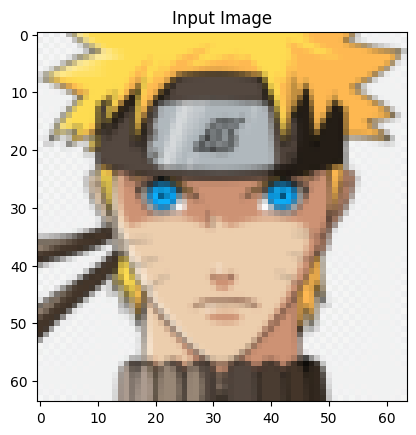

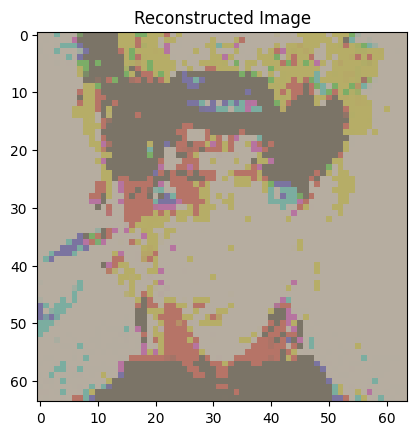

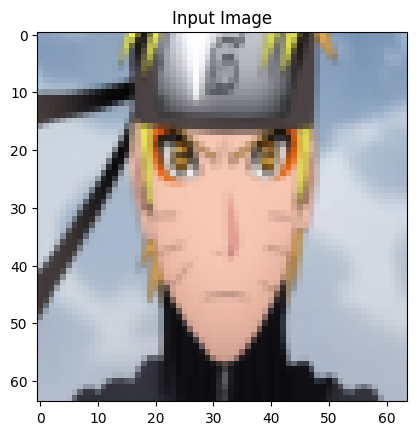

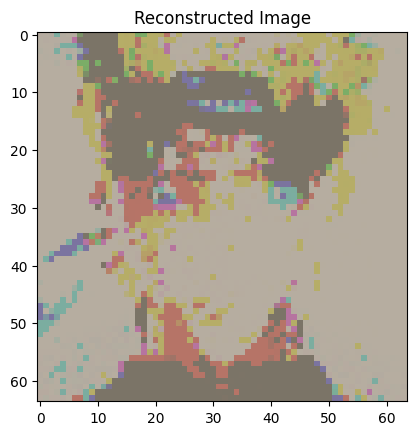

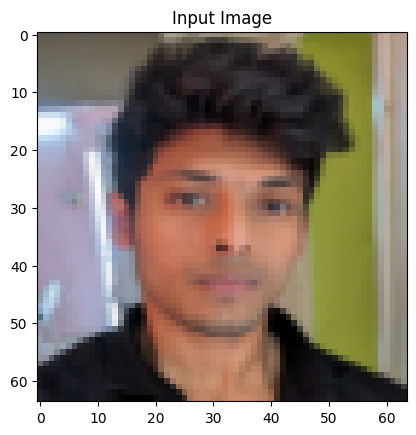

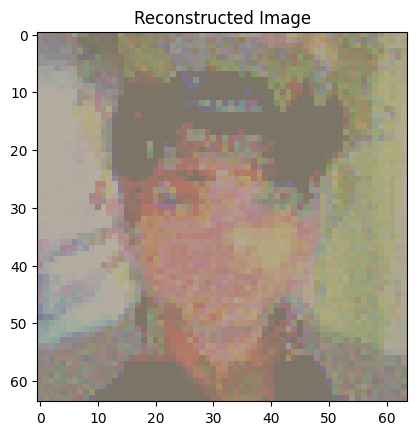

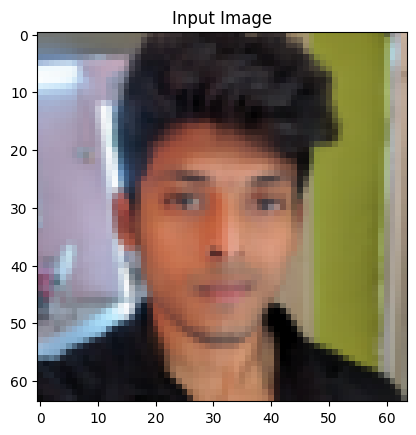

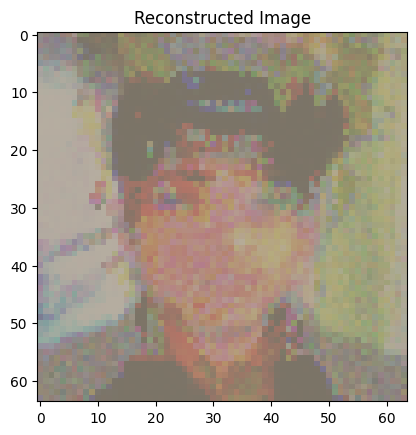

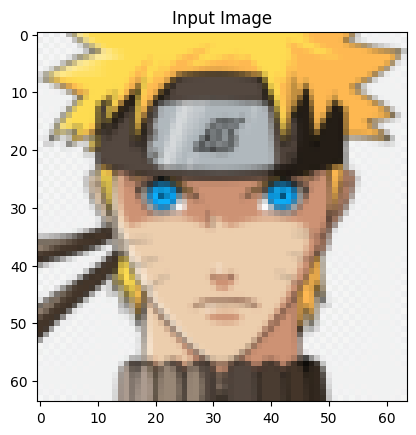

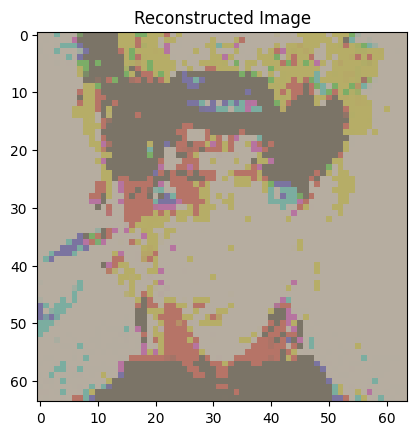

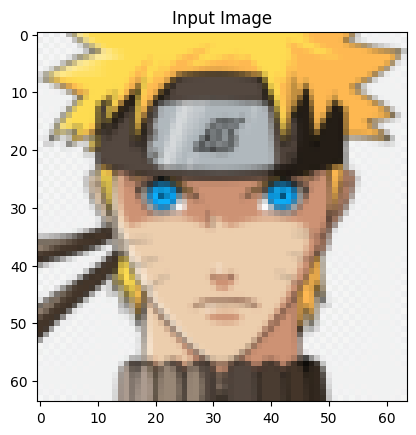

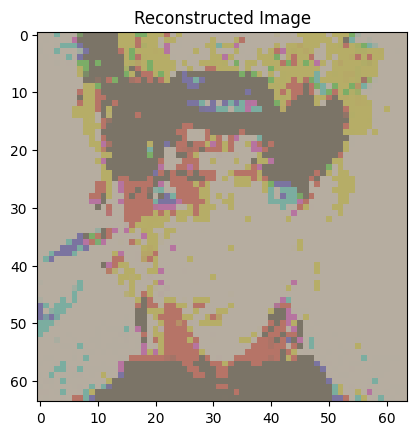

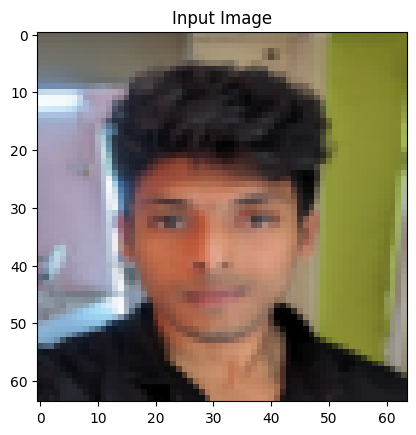

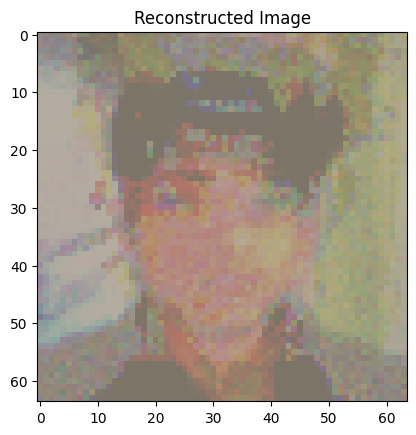

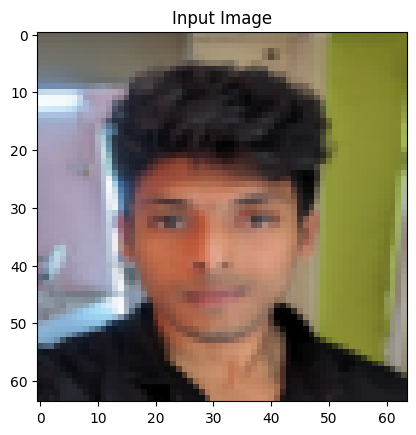

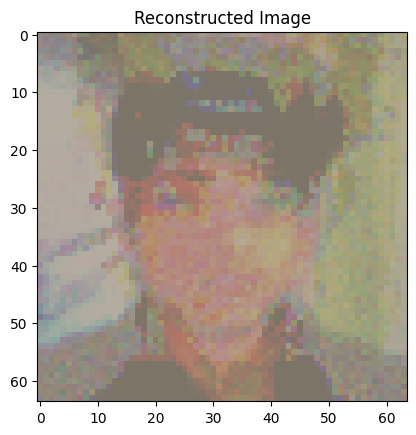

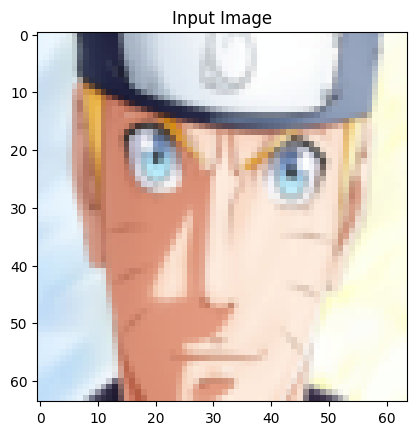

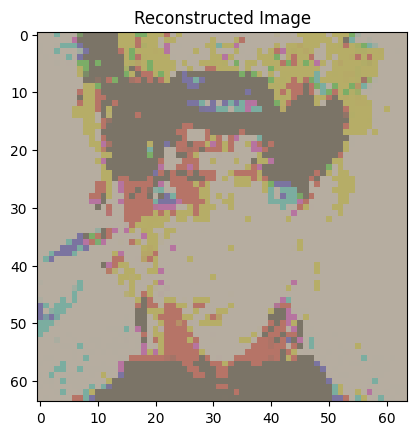

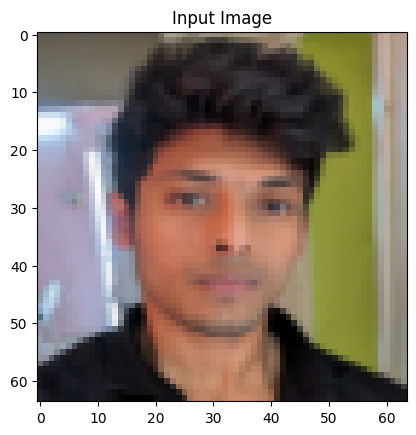

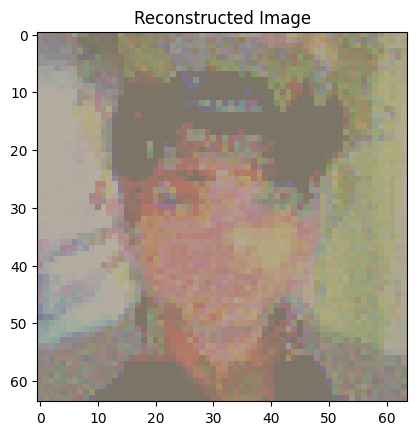

<Figure size 640x480 with 0 Axes>

In [13]:
visualize_model(model_ft,dataloaders,device)